In [1]:
# Look for possible beacons using Zeek data
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [2]:
# Rewrite using JSON python module to collect Zeek logs
ssh = SSHCommand(address='192.168.1.10', username='admin', password='password')
result = ssh.execute('echo -e \"timestamp,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts\" && zcat /nsm/zeek/logs/2022-08-15//conn.* | jq -j \'select(.conn_state == \"SF\") | .[\"ts\"], \",\", .[\"duration\"], \",\", .[\"orig_bytes\"], \",\", .[\"resp_bytes\"], \",\", .[\"orig_pkts\"], \",\", .[\"resp_pkts\"], \"\n\"\' | awk -F \":\" \'{print $1,$3}\'')

In [3]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

df = string_to_df(result)
all_pkts = df['orig_pkts'] + df['resp_pkts']
all_bytes = df['orig_bytes'] + df['resp_bytes']
df["all_pkts"] = all_pkts
df["all_bytes"] = all_bytes
df['date'] = pd.to_datetime(df['timestamp'],unit='s')
df

,timestamp,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,all_pkts,all_bytes,date
0,1.660522e+09,2.034249,50.0,114.0,1,1,2,164.0,2022-08-14 23:59:47.372040960
1,1.660522e+09,2.141306,50.0,105.0,1,1,2,155.0,2022-08-14 23:59:47.372140032
2,1.660522e+09,4.068182,93.0,243.0,2,2,4,336.0,2022-08-15 00:00:01.424998912
3,1.660522e+09,4.068970,93.0,243.0,2,2,4,336.0,2022-08-15 00:00:05.494446080
4,1.660522e+09,0.116028,87.0,148.0,4,4,8,235.0,2022-08-15 00:00:32.685538048
...,...,...,...,...,...,...,...,...,...
16128,1.660608e+09,94.427557,35393.0,107219.0,162,116,278,142612.0,2022-08-15 23:57:32.964800000
16129,1.660608e+09,74.498598,23700.0,27619.0,214,131,345,51319.0,2022-08-15 23:57:52.922764032
16130,1.660608e+09,5.381886,2290.0,2573.0,24,17,41,4863.0,2022-08-15 23:59:02.041235968
16131,1.660608e+09,0.038583,79983.0,210.0,8,15,23,80193.0,2022-08-15 23:59:07.410074112


In [4]:
# Turn this into a function to support both timestamp aggregation. Should allow user to input number of seconds to aggregate data.

from io import StringIO
import pandas as pd
import datetime

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

ts2 = df['timestamp'].iloc[0] # Get the first timestamp of the log

test = "ts,all_pkts_hour,all_bytes_hour\n"
ts_index = 0
pkts_index = 0
all_pkts_hour = 0
all_bytes_hour = 0
df_pkts = pd.DataFrame(columns=["ts","all_pkts_hour","all_bytes_hour"])
for index,value in df['timestamp'].sort_values().items():
    ts1 = value
    ts_count = value
    if ts_count >= ts2 + 3600: # if the value of the current timestamp is 3600 seconds (1 hour) equal to or greater than the previous timestamp
        all_pkts_hour = all_pkts_hour + df['all_pkts'].iloc[index] # get total packet count for this index
        all_bytes_hour = all_bytes_hour + df['all_bytes'].iloc[index]
        epoch_time = ts1
        datetime_time = datetime.datetime.fromtimestamp(epoch_time) # create ISO date from epoch_time
        test += str(datetime_time) + ',' + str(all_pkts_hour) + ',' + str(all_bytes_hour) + '\n' #build list for pandas array
        all_pkts_hour = 0
        all_bytes_hour = 0
        ts2 = value
    else: # else if the current timestamp is less than 3600 seconds than the previous timestamp
        all_pkts_hour = all_pkts_hour + df['all_pkts'].iloc[index] #increment origpkts
        all_bytes_hour = all_bytes_hour + df['all_bytes'].iloc[index] # increment respPkts

df_pkts = pd.read_csv(StringIO(str(test)), sep=",")


<AxesSubplot:xlabel='ts'>

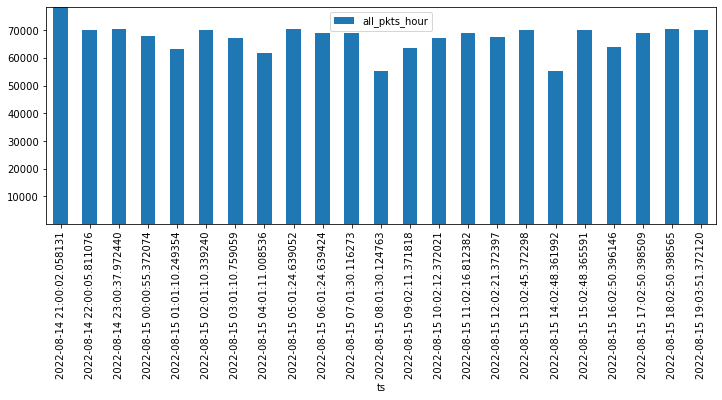

In [5]:
# Only run the following when checking the ts_count value againest an hourly rate (ts2 + 3600) in the previous cell
MAX_Y =  (df_pkts.loc[:, 'all_pkts_hour']).max()
df_pkts.plot(x="ts", y="all_pkts_hour", kind="bar", figsize=(12,4), ylim=(0.1,MAX_Y))

<AxesSubplot:xlabel='ts'>

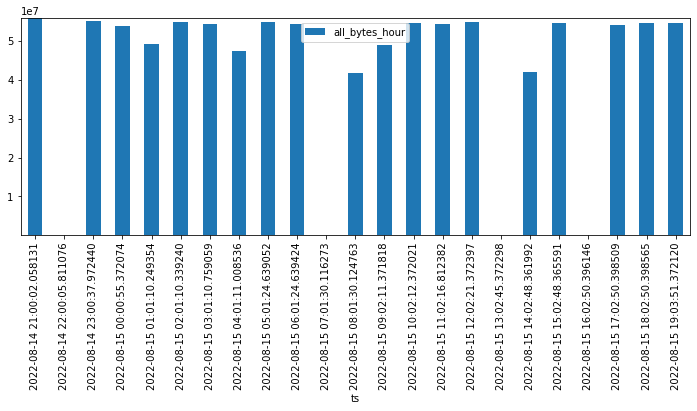

In [6]:
# Only run the following when checking the ts_count value againest an hourly rate (ts2 + 3600) in the previous cell
MAX_Y =  (df_pkts.loc[:, 'all_bytes_hour']).max()
df_pkts.plot(x="ts", y="all_bytes_hour", kind="bar", figsize=(12,4), ylim=(0.1,MAX_Y))

In [7]:
# Turn this into a function to support both timestamp aggregation. Should allow user to input number of seconds to aggregate data. See earlier cell using same functionality

ts2 = df['timestamp'].iloc[0] # Get the first timestamp of the log

test = "ts,all_pkts_seconds,all_bytes_seconds\n"
ts_index = 0
pkts_index = 0
all_pkts_seconds = 0
all_bytes_seconds = 0
df_pkts = pd.DataFrame(columns=["ts","all_pkts_seconds","all_bytes_seconds"])
for index,value in df['timestamp'].sort_values().items():
    ts1 = value
    ts_count = value
    if ts_count >= ts2 + 10: # if the value of the current timestamp is 10 seconds equal to or greater than the previous timestamp
        all_pkts_seconds = all_pkts_seconds + df['all_pkts'].iloc[index] # get total packet count for this index
        all_bytes_seconds = all_bytes_seconds + df['all_bytes'].iloc[index]
        epoch_time = ts1
        datetime_time = datetime.datetime.fromtimestamp(epoch_time) # create ISO date from epoch_time
        test += str(datetime_time) + ',' + str(all_pkts_seconds) + ',' + str(all_bytes_seconds) + '\n' #build list for pandas array
        all_pkts_seconds = 0
        all_bytes_seconds = 0
        ts2 = value
    else: # else if the current timestamp is less than 3600 seconds than the previous timestamp
        all_pkts_seconds = all_pkts_seconds + df['all_pkts'].iloc[index] #increment origpkts
        all_bytes_seconds = all_bytes_seconds + df['all_bytes'].iloc[index] # increment respPkts

df_pkts_10 = pd.read_csv(StringIO(str(test)), sep=",")


<AxesSubplot:xlabel='ts', ylabel='all_pkts_seconds'>

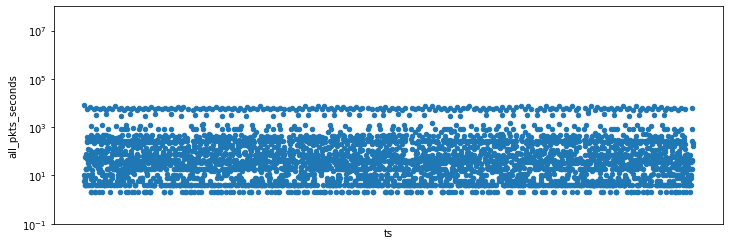

In [8]:
df_pkts_10.plot(x="ts", y="all_pkts_seconds", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,1*100000000))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_seconds'>

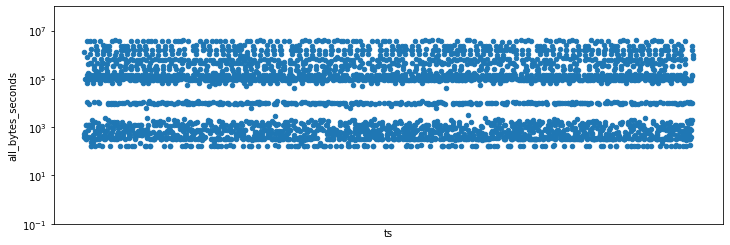

In [9]:
df_pkts_10.plot(x="ts", y="all_bytes_seconds", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,1*100000000))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_seconds'>

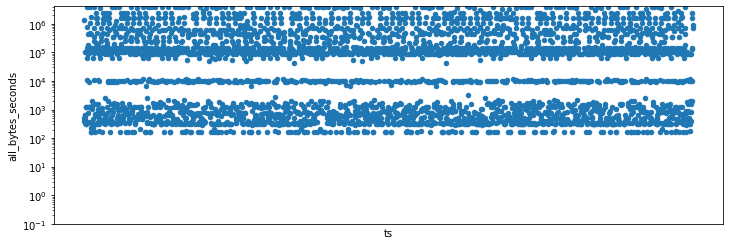

In [10]:
MAX_Y =  (df_pkts_10.loc[:, 'all_bytes_seconds']).max()
df_pkts_10.plot(x="ts", y="all_bytes_seconds", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,MAX_Y))

In [11]:
import numpy as np
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
packets = df_pkts_10.loc[:, 'all_pkts_seconds']
print(packets)
np.isnan(packets)

0       8456
1          6
2         10
3          8
4          8
        ... 
3462     836
3463    6368
3464      42
3465     227
3466     171
Name: all_pkts_seconds, Length: 3467, dtype: int64


0       False
1       False
2       False
3       False
4       False
        ...  
3462    False
3463    False
3464    False
3465    False
3466    False
Name: all_pkts_seconds, Length: 3467, dtype: bool

In [12]:
fft = np.fft.rfft(packets)
np.isnan(packets)
fft

array([ 1.59641400e+06    +0.j        ,  1.68624987e+04 -9872.2226409j ,
        1.12050601e+03 -3079.79595679j, ...,
        3.51215318e+04-39449.88884315j, -4.43959519e+04 -3986.71667367j,
       -1.56626018e+04+99573.3594961j ])

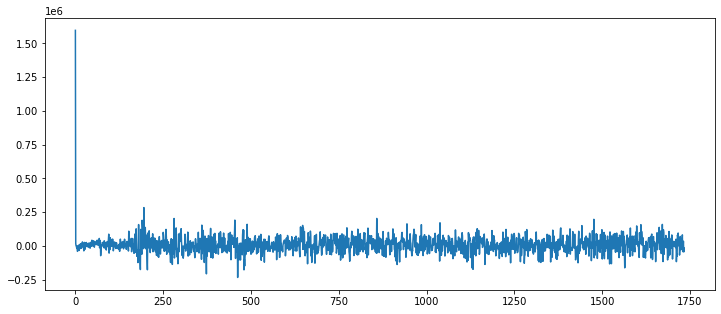

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()

In [14]:
bytesPre = df_pkts_10.loc[:, 'all_bytes_seconds']
bytes = bytesPre.dropna()
print(bytes)
np.isnan(bytes)

0       1333061.0
1           500.0
2           399.0
3           655.0
4           655.0
          ...    
3462    1574770.0
3463    2343720.0
3464     128508.0
3465     936344.0
3466     700998.0
Name: all_bytes_seconds, Length: 3462, dtype: float64


0       False
1       False
2       False
3       False
4       False
        ...  
3462    False
3463    False
3464    False
3465    False
3466    False
Name: all_bytes_seconds, Length: 3462, dtype: bool

In [15]:
fft = np.fft.rfft(bytes)
np.isnan(bytes)
fft

array([ 1.24580783e+09       +0.j        ,
        8.89806492e+06 -8337650.63043155j,
       -2.80162476e+06 -6427475.64021473j, ...,
        5.10426149e+07+61624423.77214442j,
        1.34222092e+07-22889417.76585207j,
       -7.17705820e+07       +0.j        ])

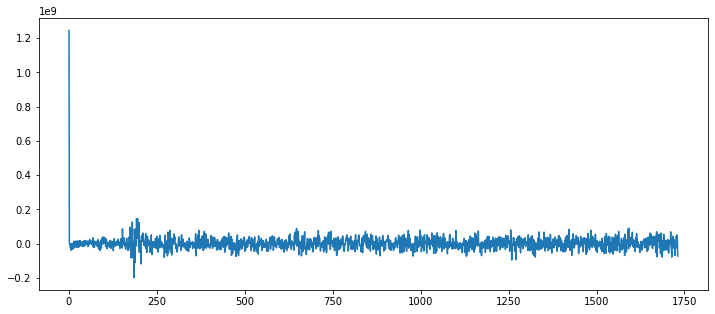

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()